**Generate data with qiskit**

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_aer import AerSimulator

The following cell is a simple experiment to show the difference of using an ideal vs noisy simulator. We are trying to map the noisy expectation value to the ideal expectation value with our model.

In [ ]:
# Initialize circuit with 2 qubits and create bell state (we still use 5 qubits to match backend)
qc = QuantumCircuit(5)
qc.h(0)
qc.cx(0,1)

# create observable ZZ for expectation value estimation
observable = SparsePauliOp("ZZZZZ")

backend = FakeManilaV2()

# use fake backend that simulates noise based on a real IBM quantum computer
noisy_backend = AerSimulator.from_backend(backend)
# use simulated backend for target values\
ideal_backend = AerSimulator()

# transpile circuit for both backends
transpiled_circuit = transpile(qc, backend)

# create estimators for both backends
noisy_estimator = EstimatorV2(noisy_backend)
ideal_estimator = EstimatorV2(ideal_backend)

# run circuits
noisy_result = noisy_estimator.run([(transpiled_circuit, observable)]).result()

ideal_result = ideal_estimator.run([(transpiled_circuit, observable)]).result()

print(f"Ideal expectation value: {ideal_result[0].data.evs}")
print(f"Noisy expectation value: {noisy_result[0].data.evs}")



Ideal expectation value: 1.0
Noisy expectation value: 0.6904296875


The ideal expectation value is 1, but our noisy (realistic) backend got a different value. We want to build a model that can map this value to its ideal expectation, given the size and depth of the state. Now we do the same thing, but we randomize our circuits with various depths, and generate 1000s of samples.

This step takes a lot of time. You can lower the num_circuits_per_depth variable if you want to generate your own smaller dataset, or skip this step and use the preloaded data I have in X_5600.csv and Y_5600.csv

In [ ]:
# build observables for specific backend
def build_observables_for_backend(backend):
    n = backend.configuration().num_qubits
    # get coupling map as list of directed edges; convert to undirected unique pairs
    try:
        coupling = backend.configuration().coupling_map
    except Exception:
        coupling = getattr(backend.configuration(), 'coupling_map', [])
    # Normalize to unique undirected edges
    edge_set = set()
    for a, b in coupling:
        edge_set.add(tuple(sorted((a, b))))
    edges = sorted(edge_set)

    observables = []

    # single Z observables ('IIZII', etc)
    for i in range(n):
        pauli = ['I'] * n
        pauli[i] = 'Z'
        observables.append(SparsePauliOp(''.join(pauli)))

    # two qubit ZZ observables for each neighboring pair of qubits
    for i, j in edges:
        pauli = ['I'] * n
        pauli[i] = 'Z'
        pauli[j] = 'Z'
        observables.append(SparsePauliOp(''.join(pauli)))
    
    return observables

# Initialize circuit with 5 qubits
num_qubits = 5
depths = [2,4,6,8,10,12,14, 16, 18, 20]
num_circuits_per_depth = 560

# use fake backend that simulates noise based on a real IBM quantum computer
backend = FakeManilaV2()
noisy_backend = AerSimulator.from_backend(backend)
# use simulated backend for target values\
ideal_backend = AerSimulator()

observables = build_observables_for_backend(noisy_backend)
# create estimators for both backends
noisy_estimator = EstimatorV2(noisy_backend)
ideal_estimator = EstimatorV2(ideal_backend)

circuits = []
noisy_result = []
ideal_result = []
# generate random circuits of varying depths. Generate many circuits per depth
for depth in depths:
    for i in range(num_circuits_per_depth):
        # create a random circuit with 2 qubit gates. Use seed to produce same data each run
        qc = random_circuit(num_qubits=num_qubits, depth=depth, max_operands=2, measure=False, seed=i)
        circuits.append(qc)
        
# transpile all circuits for both backends at once for better performance
transpiled_circuits = transpile(circuits, backend)

# run circuits
for i in range(len(circuits)):
    noisy_result.append(noisy_estimator.run([(transpiled_circuits[i], observables)]).result()[0].data.evs)
    ideal_result.append(ideal_estimator.run([(transpiled_circuits[i], observables)]).result()[0].data.evs)

# generate our data matrices
X = np.asarray(noisy_result).reshape(len(circuits), len(observables))
Y = np.asarray(ideal_result).reshape(len(circuits), len(observables))

# add more features for X
depths = np.array([qc.depth() for qc in circuits]).reshape(-1, 1)  # shape (N,1)
# standardize
scaler = StandardScaler()
depths_std = scaler.fit_transform(depths)

X_with_depth = np.concatenate([X, depths_std], axis=1)

# Save as csv so we don't have to recompute
# rename files if you want to keep data
np.savetxt('X.csv', X_with_depth, delimiter=',', fmt='%f')
np.savetxt('Y.csv', Y, delimiter=',', fmt='%f')


Below is code for a denoising autoencoder

In [59]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Autoencoder class

In [211]:
# Denoising Autoencoder model
class DAE(nn.Module): 
    def __init__(self, input_size, hidden_size=8):
        super().__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32, hidden_size)
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64, input_size - 1) #exclude depth feature
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)
            

    

# training function
def train(model, epochs, optimizer, criterion, train_loader):
    
    model = model.to(device)

    for epoch in range(epochs):
        # model.train()
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss/len(train_loader):.6f}")



Load data and convert it to tensors and torch datasets

In [208]:
# load data 
X = np.loadtxt('X_5600.csv', delimiter=',')
Y = np.loadtxt('Y_5600.csv', delimiter=',')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train,Y_train)
test_dataset = TensorDataset(X_test,Y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Train the model

In [212]:
# define our model, epochs, optimizer, and criterion
model = DAE(input_size=X_train.shape[1], hidden_size=16).to(device)
epochs = 300
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# train
train(model, epochs, optimizer, criterion, train_loader)

Epoch 0, Loss: 0.179273
Epoch 10, Loss: 0.004037
Epoch 20, Loss: 0.003604
Epoch 30, Loss: 0.003437
Epoch 40, Loss: 0.003283
Epoch 50, Loss: 0.003224
Epoch 60, Loss: 0.003165
Epoch 70, Loss: 0.003174
Epoch 80, Loss: 0.003129
Epoch 90, Loss: 0.003039
Epoch 100, Loss: 0.003115
Epoch 110, Loss: 0.003012
Epoch 120, Loss: 0.002998
Epoch 130, Loss: 0.002992
Epoch 140, Loss: 0.002939
Epoch 150, Loss: 0.002912
Epoch 160, Loss: 0.002951
Epoch 170, Loss: 0.002919
Epoch 180, Loss: 0.002903
Epoch 190, Loss: 0.002895
Epoch 200, Loss: 0.002854
Epoch 210, Loss: 0.002863
Epoch 220, Loss: 0.002860
Epoch 230, Loss: 0.002840
Epoch 240, Loss: 0.002855
Epoch 250, Loss: 0.002800
Epoch 260, Loss: 0.002801
Epoch 270, Loss: 0.002803
Epoch 280, Loss: 0.002787
Epoch 290, Loss: 0.002782


Evaluate model

In [217]:
# evaluate model
model.eval()
with torch.no_grad():
    preds = model(X_test.to(device)).cpu().numpy().clip(-1,1)

from sklearn.metrics import mean_squared_error
dae_mse = mean_squared_error(Y_test.numpy(), preds)
print("MSE:", dae_mse)

MSE: 0.00312609551474452


Compare against some simple baselines.

In [221]:
from sklearn.linear_model import LinearRegression

# --------------------------
# Baseline 1: Identity (No Denoising)
# --------------------------
identity_pred = X_test[:, :-1]  # ignore depth
mse_identity = mean_squared_error(Y_test, identity_pred)
print(f"MSE (Identity): {mse_identity:.6f}")

# --------------------------
# Baseline 2: Mean Predictor
# --------------------------
mean_Y = Y_train.mean(axis=0)
mean_pred = np.tile(mean_Y, (Y_test.shape[0], 1))
mse_mean = mean_squared_error(Y_test, mean_pred)
print(f"MSE (Mean Predictor): {mse_mean:.6f}")

MSE (Identity): 0.325709
MSE (Mean Predictor): 0.218907


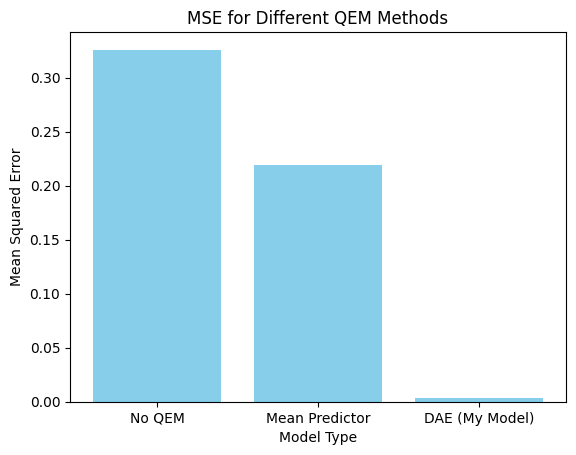

In [222]:
import matplotlib.pyplot as plt

categories = ['No QEM', 'Mean Predictor', 'DAE (My Model)']
values = [mse_identity, mse_mean, dae_mse]

plt.bar(categories, values, color='skyblue')
plt.xlabel('Model Type')
plt.ylabel('Mean Squared Error')
plt.title('MSE for Different QEM Methods')
plt.show()

In [223]:
print(f"Our model is {mse_identity / dae_mse :.2f} times better than identity baseline (no error mitigation).")

Our model is 104.19 times better than identity baseline (no error mitigation).


In [216]:
# save predictions and targets
np.savetxt('Y_pred.csv', preds, delimiter=',', fmt='%f')
np.savetxt('Y_test.csv', Y_test.numpy(), delimiter=',', fmt='%f')